In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import pandas as pd
import math
import sklearn.preprocessing as sk
from tensorboardX import SummaryWriter
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import random

In [2]:
seed = 42
random.seed(seed)
torch.cuda.manual_seed_all(seed)

N = 10000
M = 100
c = 0.5
p = 0.9
k = np.random.randn(M)
u1 = np.random.randn(M)
u1 -= u1.dot(k) * k / np.linalg.norm(k)**2
u1 /= np.linalg.norm(u1) 
k /= np.linalg.norm(k) 
u2 = k
w1 = c*u1
w2 = c*(p*u1+np.sqrt((1-p**2))*u2)
X = np.random.normal(0, 1, (N, M))
eps1 = np.random.normal(0, 0.01)
eps2 = np.random.normal(0, 0.01)
Y1 = np.matmul(X, w1) + np.sin(np.matmul(X, w1))+eps1
Y2 = np.matmul(X, w2) + np.sin(np.matmul(X, w2))+eps2
split = list(np.random.permutation(N))

X_train = X[split[0:8000],:]
Y1_train = Y1[split[0:8000]]
Y2_train = Y2[split[0:8000]]
X_valid = X[8000:9000,:]
Y1_valid = Y1[8000:9000]
Y2_valid = Y2[8000:9000]
X_test = X[9000:10000,:]
Y1_test = Y1[9000:10000]
Y2_test = Y2[9000:10000]
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(Y1_train.shape)
print(Y2_train.shape)
print(Y1_valid.shape)
print(Y2_valid.shape)
print(Y1_test.shape)
print(Y2_test.shape)

X_train = torch.from_numpy(X_train)
X_train = X_train.float()
Y1_train = torch.tensor(Y1_train)
Y1_train = Y1_train.float()
Y2_train = torch.tensor(Y2_train)
Y2_train = Y2_train.float()

X_valid = torch.from_numpy(X_valid)
X_valid = X_valid.float()
Y1_valid = torch.tensor(Y1_valid)
Y1_valid = Y1_valid.float()
Y2_valid = torch.tensor(Y2_valid)
Y2_valid = Y2_valid.float()

X_test = torch.from_numpy(X_test)
X_test = X_test.float()
Y1_test = torch.tensor(Y1_test)
Y1_test = Y1_test.float()
Y2_test = torch.tensor(Y2_test)
Y2_test = Y2_test.float()

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(Y1_train.shape)
print(Y2_train.shape)
print(Y1_valid.shape)
print(Y2_valid.shape)
print(Y1_test.shape)
print(Y2_test.shape)

(8000, 100)
(1000, 100)
(1000, 100)
(8000,)
(8000,)
(1000,)
(1000,)
(1000,)
(1000,)
torch.Size([8000, 100])
torch.Size([1000, 100])
torch.Size([1000, 100])
torch.Size([8000])
torch.Size([8000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])


In [3]:
input_size, feature_size = X.shape
shared_layer_size = 64
tower_h1 = 32
tower_h2 = 16
output_size = 1
LR = 0.001
epoch = 50
mb_size = 100
cost1tr = []
cost2tr = []
cost1D = []
cost2D = []
cost1ts = []
cost2ts = []
costtr = []
costD = []
costts = []

class MTLnet(nn.Module):
    def __init__(self):
        super(MTLnet, self).__init__()

        self.sharedlayer = nn.Sequential(
            nn.Linear(feature_size, shared_layer_size),
            nn.ReLU(),
            nn.Dropout()
        )
        self.tower1 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )
        self.tower2 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )        

    def forward(self, x):
        h_shared = self.sharedlayer(x)
        out1 = self.tower1(h_shared)
        out2 = self.tower2(h_shared)
        return out1, out2

def random_mini_batches(XE, R1E, R2E, mini_batch_size = 10, seed = 42): 
    # Creating the mini-batches
    np.random.seed(seed)            
    m = XE.shape[0]                  
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_XE = XE[permutation,:]
    shuffled_X1R = R1E[permutation]
    shuffled_X2R = R2E[permutation]
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, int(num_complete_minibatches)):
        mini_batch_XE = shuffled_XE[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_X1R = shuffled_X1R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_X2R = shuffled_X2R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    Lower = int(num_complete_minibatches * mini_batch_size)
    Upper = int(m - (mini_batch_size * math.floor(m/mini_batch_size)))
    if m % mini_batch_size != 0:
        mini_batch_XE = shuffled_XE[Lower : Lower + Upper, :]
        mini_batch_X1R = shuffled_X1R[Lower : Lower + Upper]
        mini_batch_X2R = shuffled_X2R[Lower : Lower + Upper]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    
    return mini_batches

MTL = MTLnet()
optimizer = torch.optim.Adam(MTL.parameters(), lr=LR)
loss_func = nn.MSELoss()

Iter-0; Total loss: 0.7384
Iter-1; Total loss: 0.3223
Iter-2; Total loss: 0.2236
Iter-3; Total loss: 0.2637
Iter-4; Total loss: 0.2335
Iter-5; Total loss: 0.2398
Iter-6; Total loss: 0.2266
Iter-7; Total loss: 0.1661
Iter-8; Total loss: 0.242
Iter-9; Total loss: 0.1843
Iter-10; Total loss: 0.1709
Iter-11; Total loss: 0.2011
Iter-12; Total loss: 0.1419
Iter-13; Total loss: 0.1985
Iter-14; Total loss: 0.1679
Iter-15; Total loss: 0.2013
Iter-16; Total loss: 0.1583
Iter-17; Total loss: 0.1457
Iter-18; Total loss: 0.1721
Iter-19; Total loss: 0.1883
Iter-20; Total loss: 0.1566
Iter-21; Total loss: 0.1362
Iter-22; Total loss: 0.1035
Iter-23; Total loss: 0.1652
Iter-24; Total loss: 0.2083
Iter-25; Total loss: 0.1696
Iter-26; Total loss: 0.1576
Iter-27; Total loss: 0.1523
Iter-28; Total loss: 0.1736
Iter-29; Total loss: 0.1738
Iter-30; Total loss: 0.1353
Iter-31; Total loss: 0.1564
Iter-32; Total loss: 0.1688
Iter-33; Total loss: 0.1775
Iter-34; Total loss: 0.1693
Iter-35; Total loss: 0.1448
Ite

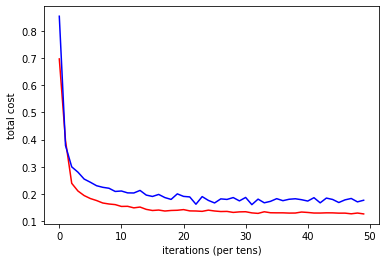

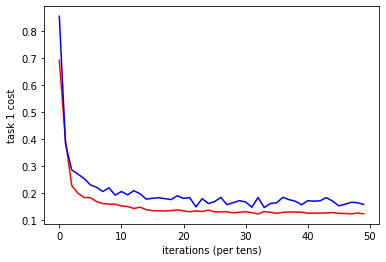

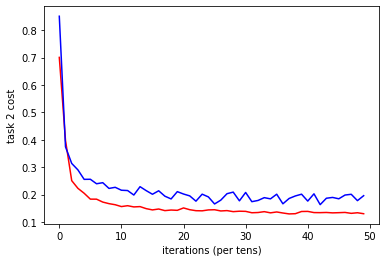

In [4]:
for it in range(epoch):
    epoch_cost = 0
    epoch_cost1 = 0
    epoch_cost2 = 0
    num_minibatches = int(input_size / mb_size) 
    minibatches = random_mini_batches(X_train, Y1_train, Y2_train, mb_size)
    for minibatch in minibatches:
        XE, YE1, YE2  = minibatch 
        
        Yhat1, Yhat2 = MTL(XE)
        l1 = loss_func(Yhat1, YE1.view(-1,1))    
        l2 = loss_func(Yhat2, YE2.view(-1,1))
        loss =  (l1 + l2)/2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_cost = epoch_cost + (loss / num_minibatches)
        epoch_cost1 = epoch_cost1 + (l1 / num_minibatches)
        epoch_cost2 = epoch_cost2 + (l2 / num_minibatches)
    costtr.append(torch.mean(epoch_cost))
    cost1tr.append(torch.mean(epoch_cost1))
    cost2tr.append(torch.mean(epoch_cost2))
    with torch.no_grad():
        Yhat1D, Yhat2D = MTL(X_valid)
        l1D = loss_func(Yhat1D, Y1_valid.view(-1,1))
        l2D = loss_func(Yhat2D, Y2_valid.view(-1,1))
        cost1D.append(l1D)
        cost2D.append(l2D)
        costD.append((l1D+l2D)/2)
        print('Iter-{}; Total loss: {:.4}'.format(it, loss.item()))
    
plt.plot(np.squeeze(costtr), '-r',np.squeeze(costD), '-b')
plt.ylabel('total cost')
plt.xlabel('iterations (per tens)')
plt.show() 

plt.plot(np.squeeze(cost1tr), '-r', np.squeeze(cost1D), '-b')
plt.ylabel('task 1 cost')
plt.xlabel('iterations (per tens)')
plt.show() 

plt.plot(np.squeeze(cost2tr),'-r', np.squeeze(cost2D),'-b')
plt.ylabel('task 2 cost')
plt.xlabel('iterations (per tens)')
plt.show()